In [9]:
import os
import json
import autoroot
import autorootcwd
# Load annotations
annotations = []
base_dir = "data"  # Replace with your actual path
for root, _, files in os.walk(base_dir):
    for file in files:
        if file == "via_region_data.json":
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
                for key, annotation in data.items():  # Assuming VIA annotations are stored in a dictionary
                    annotation["path"] = os.path.relpath(root, base_dir)
                annotations.extend(data.values())  # Assuming VIA annotations are stored in a dictionary

In [11]:
annotation_to_class = {
    "Front": [
        "bonnet", "frontbumper", "frontws", "headlightwasher", "indicator",
        "leftheadlamp", "rightheadlamp", "frontbumpergrille", "lowerbumpergrille",
        "licenseplate", "namebadge"
    ],
    "Rear": [
        "rearbumper", "rearws", "fuelcap", "taillamp", "rearbumpercladding",
        "leftbootlamp", "rightbootlamp", "towbarcover", "lefttailgate",
        "righttailgate", "rearbumpermissing", "rearwsmissing"
    ],
    "Front-Right": [
        "rightfender", "rightfrontdoor", "rightfrontdoorglass", "rightorvm",
        "rightfoglamp", "partial_rightfender", "partial_rightfrontdoor",
        "rightfrontbumper"
    ],
    "Front-Left": [
        "leftfender", "leftfrontdoor", "leftfrontdoorglass", "leftorvm",
        "leftfoglamp", "partial_leftfender", "partial_leftfrontdoor",
        "leftfrontbumper"
    ],
    "Rear-Right": [
        "rightqpanel", "rightreardoor", "rightreardoorglass", "rightrearventglass",
        "partial_rightqpanel", "partial_rightreardoor", "rightrearbumper"
    ],
    "Rear-Left": [
        "leftqpanel", "leftreardoor", "leftreardoorglass", "leftrearventglass",
        "partial_leftqpanel", "partial_leftreardoor", "leftrearbumper"
    ],
    "None": [
        "alloywheel", "antenna", "car", "cracked", "dirt", "logo", "reflection",
        "rust", "scratch", "shattered", "sensor", "sunroof", "wiper", "series"
    ]
}


In [12]:
import pandas as pd

# Initialize the result list
image_data = []

#########################################################
# THRESHOLD_FACTOR: how many times bigger "None" must be
# than any other label to be chosen as the final label.
#########################################################
THRESHOLD_FACTOR = 2.0  

for annotation in annotations:
    file_name = annotation['filename']
    regions = annotation.get('regions', [])
    
    annotation_list = []
    annotation_areas = []
    class_labels = []
    class_areas = []
    
    # Initialize the label area map with every known class + 'None' to 0
    label_area_map = {label: 0 for label in annotation_to_class.keys()}
    label_area_map['None'] = 0

    # --- Process each region ---
    for region in regions:
        shape_attributes = region['shape_attributes']
        region_attributes = region['region_attributes']

        # Extract the annotation name from 'identity'
        annotation_name = region_attributes.get('identity', 'None')

        # Determine which class label it belongs to (if any)
        label = next(
            (key for key, values in annotation_to_class.items() 
             if annotation_name in values),
            'None'
        )

        # Calculate the area of the annotation
        if shape_attributes.get('name') == 'polygon':
            x = shape_attributes['all_points_x']
            y = shape_attributes['all_points_y']
            area = 0.5 * abs(sum(x[i] * y[i+1] - x[i+1] * y[i] 
                                 for i in range(-1, len(x)-1)))
        else:
            # In case of other shapes, set area to 0 or handle differently
            area = 0

        # Append the raw annotation data
        annotation_list.append(annotation_name)
        annotation_areas.append(area)

        # If we haven't seen this class label yet, initialize; otherwise add to it
        if label not in class_labels:
            class_labels.append(label)
            class_areas.append(area)
        else:
            class_areas[class_labels.index(label)] += area

        # Update the total area for this label
        label_area_map[label] += area

    # --- Determine the final label --- 
    if not annotation_list:
        # If there are NO annotations at all, final_label = 'None'
        final_label = 'None'
    else:
        # Separate 'None' area from other labels' areas
        none_area = label_area_map.get('None', 0)
        # Dictionary with everything except 'None'
        label_area_map_no_none = {
            k: v for k, v in label_area_map.items() if k != 'None'
        }

        if not label_area_map_no_none:
            # If the only label is 'None', final_label = 'None'
            final_label = 'None'
        else:
            # Find the label with the largest area among non-'None'
            max_non_none_label = max(label_area_map_no_none, key=label_area_map_no_none.get)
            max_non_none_area = label_area_map_no_none[max_non_none_label]

            # Compare 'None' area vs. largest non-'None' area
            if none_area > THRESHOLD_FACTOR * max_non_none_area:
                final_label = 'None'
            else:
                final_label = max_non_none_label
    
    # Optional: print debug info
    print(f"label_area_map: {label_area_map} -> final_label: {final_label}")

    # --- Append data to the result list ---
    image_data.append({
        "path": annotation["path"],
        'image': file_name,
        'annotations': annotation_list,
        'ann_areas': annotation_areas,
        'class_labels': class_labels,
        'class_areas': class_areas,
        'final_label': final_label
    })

# Convert to DataFrame
df = pd.DataFrame(image_data)
print("\nFinal DataFrame:")
df.head()

label_area_map: {'Front': 116126.5, 'Rear': 0, 'Front-Right': 237405.5, 'Front-Left': 0, 'Rear-Right': 27083.5, 'Rear-Left': 0, 'None': 127198.0} -> final_label: Front-Right
label_area_map: {'Front': 0, 'Rear': 68769.29500000004, 'Front-Right': 0, 'Front-Left': 0, 'Rear-Right': 172179.42999999996, 'Rear-Left': 0, 'None': 100145.97000000003} -> final_label: Rear-Right
label_area_map: {'Front': 0, 'Rear': 0, 'Front-Right': 0, 'Front-Left': 235766.5, 'Rear-Right': 0, 'Rear-Left': 170823.5, 'None': 157753.0} -> final_label: Front-Left
label_area_map: {'Front': 94415.0, 'Rear': 0, 'Front-Right': 267407.5, 'Front-Left': 0, 'Rear-Right': 0, 'Rear-Left': 0, 'None': 230202.0} -> final_label: Front-Right
label_area_map: {'Front': 11565.0, 'Rear': 0, 'Front-Right': 639825.0, 'Front-Left': 0, 'Rear-Right': 0, 'Rear-Left': 0, 'None': 273586.0} -> final_label: Front-Right
label_area_map: {'Front': 13471.5, 'Rear': 349221.0, 'Front-Right': 0, 'Front-Left': 0, 'Rear-Right': 0, 'Rear-Left': 0, 'None': 

,path,image,annotations,ann_areas,class_labels,class_areas,final_label
0,6024c8bf5b913441612636e2,scraped_oNcT73_1612877048168.jpg,"[rightorvm, rightfrontdoor, frontws, rightrunn...","[17769.5, 152204.0, 113707.0, 10960.5, 2379.0,...","[Front-Right, Front, None, Rear-Right]","[237405.5, 116126.5, 127198.0, 27083.5]",Front-Right
1,6024c8bf5b913441612636e2,scraped_RBMuQy_1612877819726.jpg,"[righttaillamp, rightqpanel, rearbumper, doorh...","[27993.910000000007, 62330.60999999999, 68769....","[None, Rear-Right, Rear]","[100145.97000000003, 172179.42999999996, 68769...",Rear-Right
2,6024c8bf5b913441612636e2,scraped_kM5Ybk_1612870503323.jpg,"[leftrunningboard, leftfrontdoor, doorhandle, ...","[24736.5, 235766.5, 4247.5, 170823.5, 10664.0,...","[None, Front-Left, Rear-Left]","[157753.0, 235766.5, 170823.5]",Front-Left
3,6024c8bf5b913441612636e2,scraped_E1iMRz_1612878020633.jpg,"[rightfender, rightorvm, tyre, wheelcap, bonne...","[223855.5, 43552.0, 117990.5, 49737.0, 94415.0...","[Front-Right, None, Front]","[267407.5, 230202.0, 94415.0]",Front-Right
4,6024c8bf5b913441612636e2,scraped_vYNkZe_1612870519056.jpg,"[rightfender, tyre, alloywheel, indicator, scr...","[639825.0, 193535.5, 67696.5, 11565.0, 12354.0]","[Front-Right, None, Front]","[639825.0, 273586.0, 11565.0]",Front-Right


In [13]:
# Add a new column for multi-class labels
def calculate_multi_class_labels(row, threshold=0.1):
    if row["class_areas"] == []:
        return ['None']
    largest_area = max(row["class_areas"])
    multi_class_labels = [
        label for label, area in zip(row["class_labels"], row["class_areas"])
        if area >= threshold * largest_area
    ]
    return multi_class_labels

df["multi_class_labels"] = df.apply(calculate_multi_class_labels, axis=1)
df.head()


,path,image,annotations,ann_areas,class_labels,class_areas,final_label,multi_class_labels
0,6024c8bf5b913441612636e2,scraped_oNcT73_1612877048168.jpg,"[rightorvm, rightfrontdoor, frontws, rightrunn...","[17769.5, 152204.0, 113707.0, 10960.5, 2379.0,...","[Front-Right, Front, None, Rear-Right]","[237405.5, 116126.5, 127198.0, 27083.5]",Front-Right,"[Front-Right, Front, None, Rear-Right]"
1,6024c8bf5b913441612636e2,scraped_RBMuQy_1612877819726.jpg,"[righttaillamp, rightqpanel, rearbumper, doorh...","[27993.910000000007, 62330.60999999999, 68769....","[None, Rear-Right, Rear]","[100145.97000000003, 172179.42999999996, 68769...",Rear-Right,"[None, Rear-Right, Rear]"
2,6024c8bf5b913441612636e2,scraped_kM5Ybk_1612870503323.jpg,"[leftrunningboard, leftfrontdoor, doorhandle, ...","[24736.5, 235766.5, 4247.5, 170823.5, 10664.0,...","[None, Front-Left, Rear-Left]","[157753.0, 235766.5, 170823.5]",Front-Left,"[None, Front-Left, Rear-Left]"
3,6024c8bf5b913441612636e2,scraped_E1iMRz_1612878020633.jpg,"[rightfender, rightorvm, tyre, wheelcap, bonne...","[223855.5, 43552.0, 117990.5, 49737.0, 94415.0...","[Front-Right, None, Front]","[267407.5, 230202.0, 94415.0]",Front-Right,"[Front-Right, None, Front]"
4,6024c8bf5b913441612636e2,scraped_vYNkZe_1612870519056.jpg,"[rightfender, tyre, alloywheel, indicator, scr...","[639825.0, 193535.5, 67696.5, 11565.0, 12354.0]","[Front-Right, None, Front]","[639825.0, 273586.0, 11565.0]",Front-Right,"[Front-Right, None]"


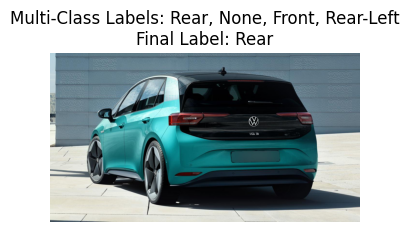

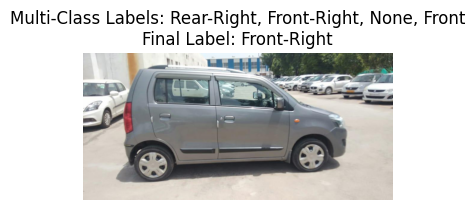

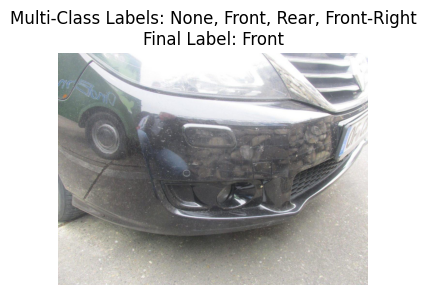

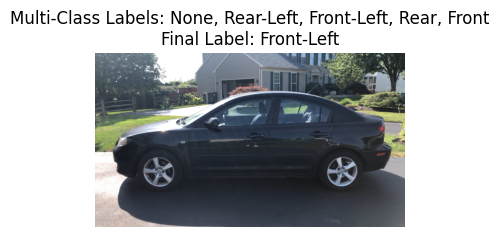

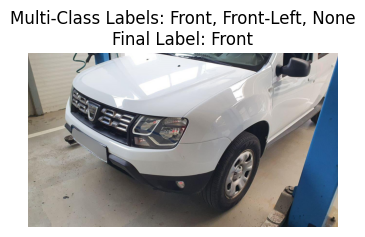

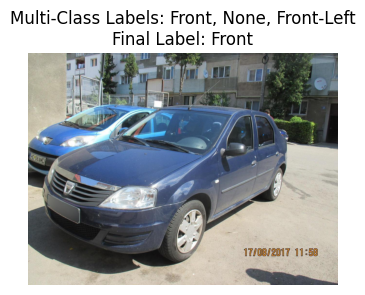

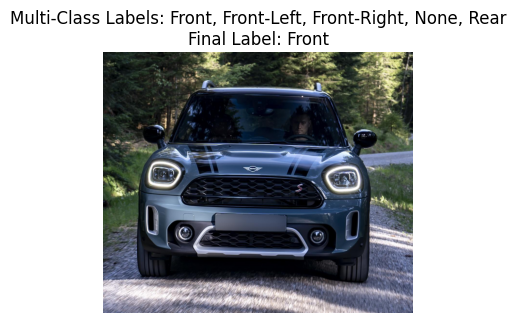

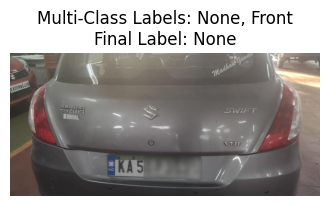

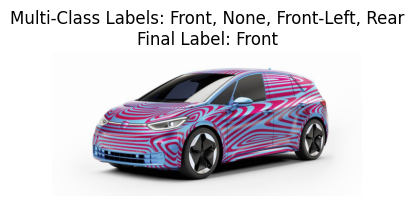

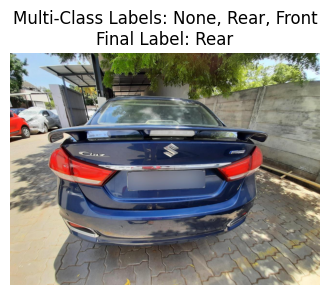

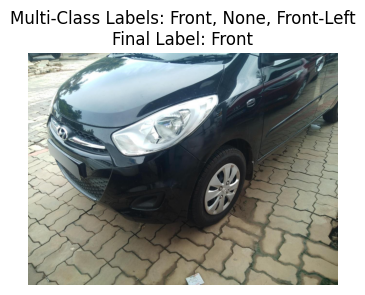

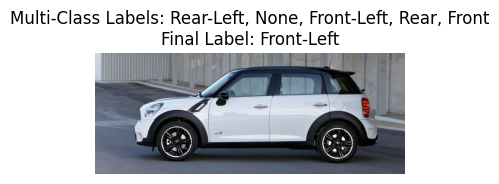

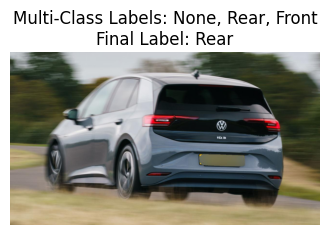

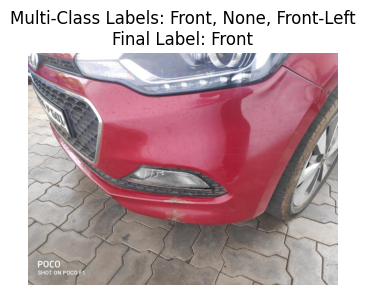

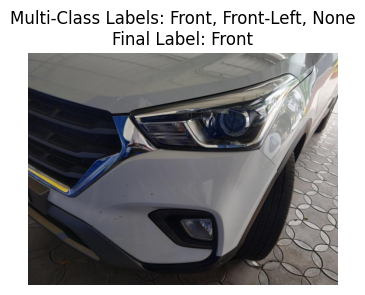

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

sampled_df = df.sample(n=15, random_state=50)

# Plot images with multi-class labels and final labels
for index, row in sampled_df.iterrows():
    image_path = f"{base_dir}/{row['path']}/{row['image']}"
    try:
        # Load image
        img = Image.open(image_path)
        
        # Plot image
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Multi-Class Labels: {', '.join(row['class_labels'])}\nFinal Label: {row['final_label']}")
        plt.show()
    except FileNotFoundError:
        print(f"Image not found: {image_path}")


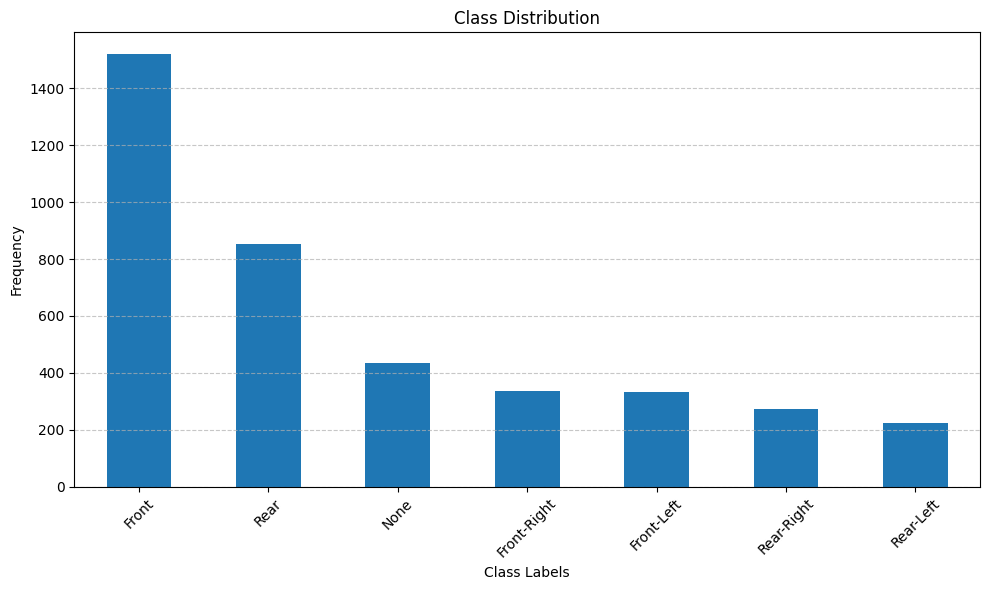

final_label
Front          1521
Rear            854
None            434
Front-Right     336
Front-Left      333
Rear-Right      272
Rear-Left       224
Name: count, dtype: int64


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a pandas DataFrame called `df`
# and the `final_label` column contains the class labels

# Calculate class distribution
class_distribution = df['final_label'].value_counts()

# Plot the class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print the class distribution
print(class_distribution)


In [16]:
from sklearn.model_selection import train_test_split

# Stratified split into train and temp (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.08,  # Adjust this based on desired val + test size
    random_state=42,
    shuffle=True,
    stratify=df["final_label"]  # Use the column containing class labels
)

# Stratified split of temp into val and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # 50% of temp goes to test, 50% to val
    random_state=42,
    stratify=temp_df["final_label"]
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 3656, Val size: 159, Test size: 159


In [17]:
train_df.to_json("data/training_data.json", orient='records', lines=True)
val_df.to_json("data/val_data.json", orient='records', lines=True)
test_df.to_json("data/test_data.json", orient='records', lines=True)


In [20]:
import math

# Parameters
p = 0.85  # Expected accuracy
N = 159   # Test set size

# Variability calculation
variability = math.sqrt((p * (1 - p)) / N) * 100
variability


2.8317605697742705